<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre strained model experiment with augmented dataset


This notebook contains data processing, models, experiements and evaluation of the Oncological image data. The analysis in the notebook is focused on the effects image augmentation has on tree models considered such as:

*   ResNet50
*   VGG16
*   GoogleNet


In [2]:
##################################################
# Imports and setting the seed
##################################################

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model
from torchvision import models,transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- **Loading Labeled Dataset**: A significant step involves loading the labeled dataset directly from a CSV file housing image labels.
- **Determining Maximum Size**: Careful computation of the maximum width and height of the images within the dataset is performed.
    - **Data Transformation**: Two primary data transformation pipelines are meticulously delineated:
        - `main_transform`: This pipeline chiefly centers on resizing images to the determined maximum width and height, converting them into tensors, and applying vital normalization.
        - `augmentation_transform`: Extending its utility beyond mere resizing, this pipeline incorporates a spectrum of augmentation techniques, including random flips, rotation, color jitter, and normalization.
    - **Dataset Creation**: Leveraging the versatile `CustomDataset` class, both the main dataset and augmented dataset are skillfully instantiated, each tailored to its respective transformation pipeline.
    - **Combining Datasets**: A pivotal fusion operation is executed, amalgamating the main dataset and the augmented dataset with the aid of the `ConcatDataset` class.
    - **Stratified k-Fold Cross-Validation**: To fortify the integrity of the training process, the combined dataset undergoes a stratified k-fold cross-validation procedure, deftly partitioning it into distinct train and validation sets.

In [3]:
##################################################
# Setting the device and check if GPU is available
##################################################
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

GPU enabled!


In [4]:
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
#read the labeled data
labeled_data = pd.read_csv(labels_file_path)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

In [5]:
#Let's define a proper list of the labeled images
#3 classes are available, 1, 0, -1
tr = pd.read_csv(os.path.join(image_directory,'labels.csv'))
tr['Image_id'] = ''
for i in range(len(tr)):
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
tr.head()

<ipython-input-5-37b977ffbd52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'


,id,malignant,Image_id
0,441,-1,img_441.png
1,33284,-1,img_33284.png
2,38771,1,img_38771.png
3,46784,-1,img_46784.png
4,57613,-1,img_57613.png


Deal with data transformation

In [6]:
#Non labeled
os.chdir("/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification")
!ls

img_103601.png	img_279108.png	img_405863.png	img_591760.png	img_76700.png	img_885489.png
img_105480.png	img_28148.png	img_407269.png	img_612835.png	img_769175.png	img_900056.png
img_112905.png	img_289758.png	img_422011.png	img_615166.png	img_777273.png	img_901399.png
img_118847.png	img_291326.png	img_422756.png	img_630916.png	img_779084.png	img_906866.png
img_125877.png	img_292784.png	img_433126.png	img_646642.png	img_779156.png	img_912471.png
img_131043.png	img_292971.png	img_433757.png	img_655750.png	img_78884.png	img_914133.png
img_133778.png	img_295118.png	img_439840.png	img_662528.png	img_789519.png	img_918503.png
img_133962.png	img_296778.png	img_441.png	img_666409.png	img_791326.png	img_930969.png
img_135878.png	img_298233.png	img_467694.png	img_671361.png	img_791719.png	img_931110.png
img_136044.png	img_303169.png	img_46784.png	img_67212.png	img_792150.png	img_931650.png
img_139077.png	img_308363.png	img_471401.png	img_673711.png	img_799907.png	img_93671.png
img_145106.png	img_

<ipython-input-20-d7b16916e945>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immagini = tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
<ipython-input-20-d7b16916e945>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30, 20))


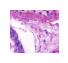

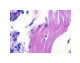

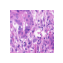

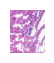

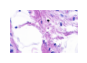

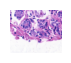

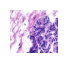

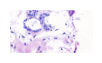

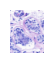

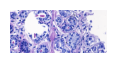

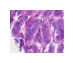

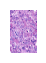

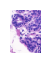

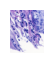

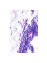

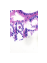

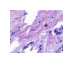

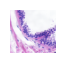

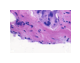

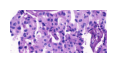

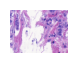

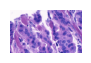

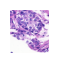

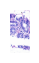

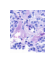

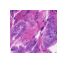

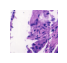

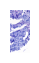

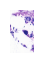

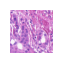

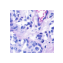

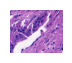

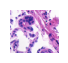

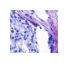

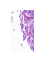

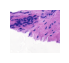

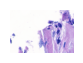

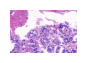

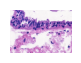

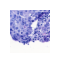

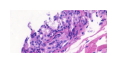

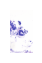

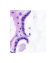

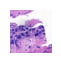

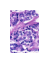

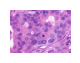

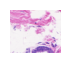

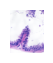

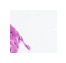

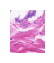

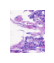

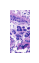

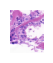

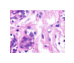

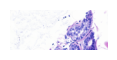

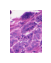

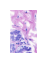

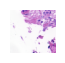

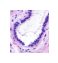

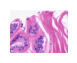

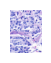

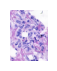

In [20]:
##################################################
# Visualize Images of dataset
##################################################

for i in range(len(tr)):
  plt.figure(figsize=(30, 20))
  plt.subplot(30, 20, i + 1)
  immagini = tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
  img = Image.open(immagini)
  plt.axis('off')
  plt.imshow(img)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

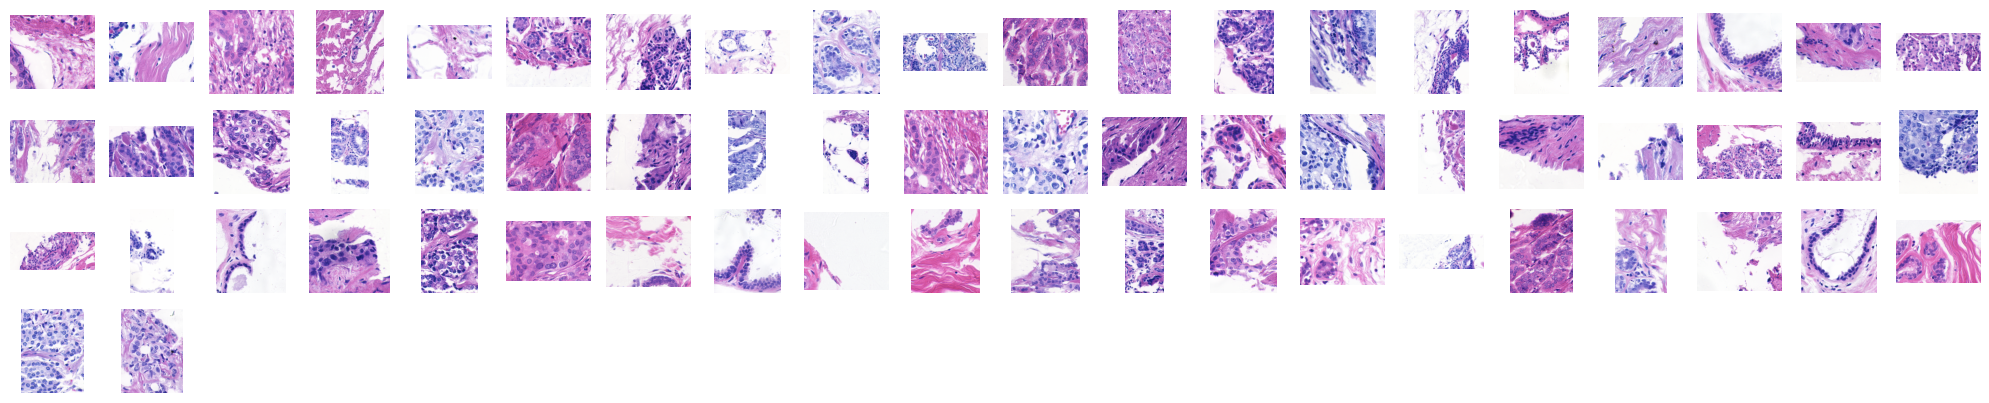

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'tr' is a DataFrame with image information

# Set the number of rows and columns for the subplot grid
num_rows = 30
num_cols = 20

# Set the figure size based on the number of rows and columns
plt.figure(figsize=(num_cols, num_rows))

# Loop through the images in 'tr' and plot them
for i in range(len(tr)):
    # Generate the image filename
    image_filename = 'img_' + str(tr.loc[i, 'id']) + '.png'

    # Read the image using PIL
    img = Image.open(image_filename)

    # Calculate subplot index based on the loop variable 'i'
    subplot_index = i + 1

    # Plot the image at the calculated subplot index
    plt.subplot(num_rows, num_cols, subplot_index)

    # Turn off axis labels
    plt.axis('off')

    # Display the image
    plt.imshow(img)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


# Dataset pre-processing section:

The following lines until the modelling part, will be focused on data augmentation, k-fold cross-validation, and model training. The components related to data splitting is defined as stacked dataset that represent the combination of original dataset and augmented datasets.
The other most important pre processing part is the k-fold cross-validation on stacked dataset for model evaluation. Inside the loop over folds, training data and validation data are respectivelly splitted in data into training and validation sets.

The `CustomDataset` class is a fundamental step for loading and preprocessing image data. It works with inputs such as the image directory, labels file, and optional transformations. Within this class, key methods are employed for gauging dataset length and retrieving individual data items.


In [7]:
##################################################
# Data pre-processing section
##################################################

#Since this is the augmente experiment, to provide filenames and labels explicitly or read them from a CSV file because It supports image transformations for data augmentation

class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset builder section.
        Parameters considered in the function:
        - transform which is an optional transform to be applied to the images.
        - provided_filenames which represent the list of filenames corresponding to the images.
        - provided_labels that correspornd to the list of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        Function to get the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and image processing libraries expect images to be in RGB format for consistency.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [8]:
max_width = 0
max_height = 0
#Store the image's dimensions info
for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

In [9]:
# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
Transformation section:
The goal of the following parti si to augment data
by resizing the images to the maximum width and heigh updated,
then converts them to tensors, and applies normalization to be recognized by algorithms.
'''

dataset = CustomDataset(image_directory, labels_file_path, transform=main_transform)
'''
All the transformations are here written such as the resizing, flipping, color transformation
and also the normalization
'''
augmentation_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_augmented = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform)


# Second transformation section with additional transformation and change in parameters
augmentation_transform_2 = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((max_height, max_width), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_augmented_2 = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform_2)

stacked_dataset = ConcatDataset([dataset, dataset_augmented])
'''
Combine the main dataset and the augmented dataset using ConcatDataset.
This merge the two dataset into a single dataset that contains both original and augmented data.
'''

stacked_labels = np.concatenate([labels, labels])
'''
Concatenate the labels array with itself to match the combined dataset size.
This is fundamental to have that labels are aligned with the corresponding images in stacked_dataset.
'''


k_folds = 8
# Number of folds of k-fold cross-validation (CV).

# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
'''
Create an instance of stratified k-fold cross-validation.
As seen from theory it splits the data into k folds while preserving the class distribution.
The shuffle parameter is set to True to shuffle the data before splitting,
and the random_state is considered for reproducibility.
'''

#fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    # Iterate over each fold generated by the StratifiedKFold object.

    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [stacked_dataset[idx] for idx in train_index]
    val_data = [stacked_dataset[idx] for idx in val_index]
    '''
    Obtain the indices for the training and validation data for the current fold
    and extract the corresponding data from the stacked_dataset.
    '''

    # Convert labels to numpy array for indexing
    stacked_labels = np.array(stacked_labels)
    # Convert the stacked_labels to a numpy array for easier indexing.


    # Calculate class weights
    weights_of_classes = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    '''
    Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    This gives more weight to underrepresented classes and less weight to overrepresented classes.
    '''
    train_class_weights = weights_of_classes[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.


    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    '''
    Create a WeightedRandomSampler, which samples elements from the training data with replacement
    according to the specified class weights. This oversamples the underrepresented classes
    during training to balance the class distribution.
    '''

    # Create the data loaders with weighted sampling
    batch_size = 6
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each epoch is not needed in validation.

Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


In [ ]:
'''
for k, v in tr.items():
  print(k)
  plt.figure(figsize=(25, 20))
  for idx in range(20):
      plt.subplot(1, 20, idx + 1)
      #img = np.array(v[idx].reshape(28,28))
      #plt.title(f'{y_labels[new_y_test[idx]]}')
      labels_df = pd.read_csv(labels_file_path)
      labels = labels_df['malignant'].values + 1
      filenames = labels_df['id'].astype(str).values
      img_path = os.path.join(image_directory, 'img_' + str(filenames[idx]) + '.png')
      #plt.imshow(img_path, cmap='gray')
      plt.axis('off')
      plt.show(img_path)
'''

# Models and experiment with epochs

This section contains our model builds for the upcoming eperiments. The following models will be used:

*   Resnet model
*   VGG-16 model
*   Google Net model

**Model setting**:
- **Pre-trained model loading**: Several pre-trained models from the torchvision library are loaded, including ResNet50, VGG16 and GoogLeNet.
- **Model customization**: The last fully connected layers (classifiers) of each model are replaced with new linear layers to match the number of classes in the current task.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - ResNet50 Training Loss: 1.3021
Epoch 2/15 - ResNet50 Training Loss: 1.1276
Epoch 3/15 - ResNet50 Training Loss: 1.0266
Epoch 4/15 - ResNet50 Training Loss: 0.9487
Epoch 5/15 - ResNet50 Training Loss: 0.9183
Epoch 6/15 - ResNet50 Training Loss: 1.0271
Epoch 7/15 - ResNet50 Training Loss: 0.8816
Epoch 8/15 - ResNet50 Training Loss: 0.8199
Epoch 9/15 - ResNet50 Training Loss: 1.0190
Epoch 10/15 - ResNet50 Training Loss: 0.7515
Epoch 11/15 - ResNet50 Training Loss: 0.9794
Epoch 12/15 - ResNet50 Training Loss: 0.8808
Epoch 13/15 - ResNet50 Training Loss: 0.9445
Epoch 14/15 - ResNet50 Training Loss: 0.7506
Epoch 15/15 - ResNet50 Training Loss: 0.7475


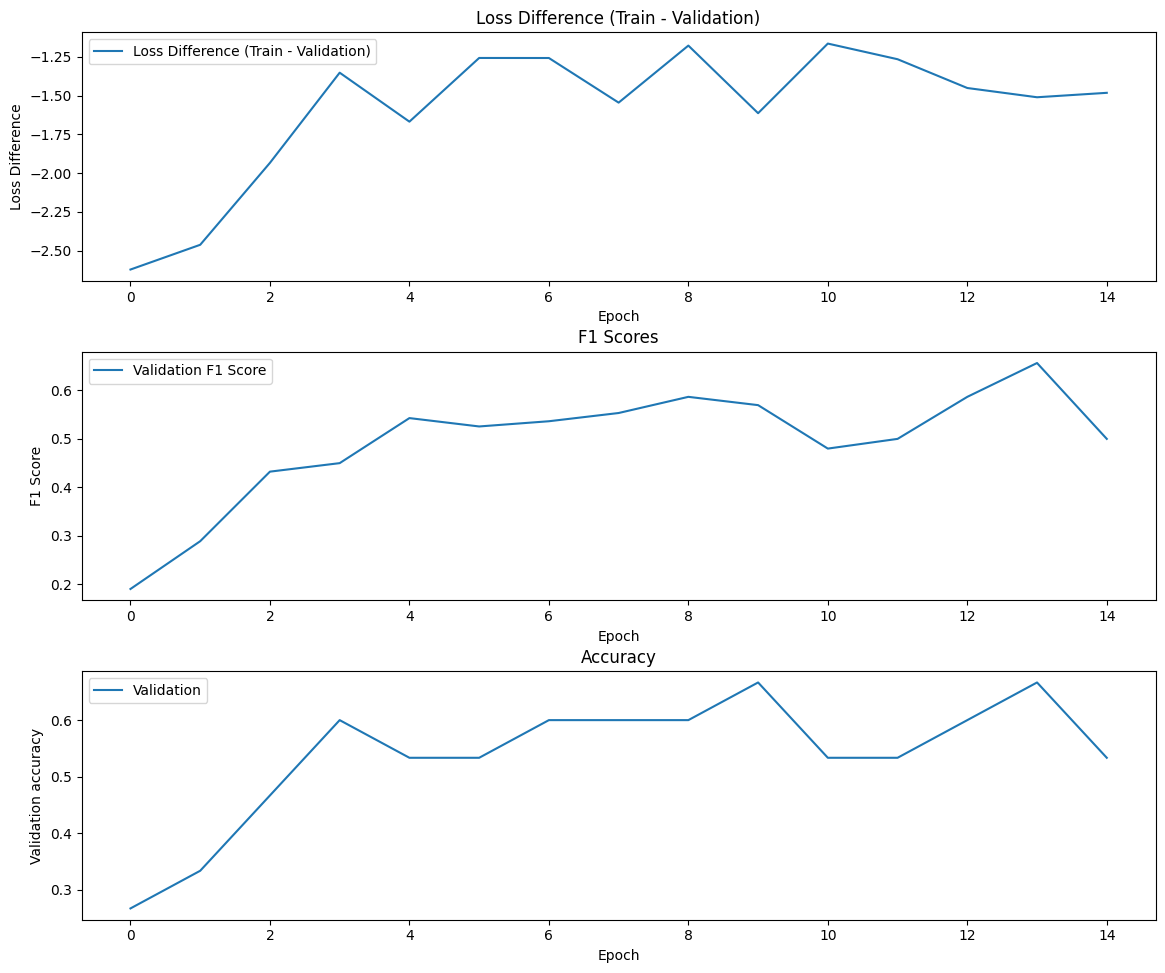

In [ ]:
##################################################
# Resnet 50
##################################################

resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device
resnet_model = resnet_model.to(device)

#Loss function
parameter_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)

# Lists to store training and validation losses and F1 scores
train_losses = []
val_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []

# Training loop
num_epochs = 15


#For the experiments change train_dataloader do train_data


for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

#Change from subset_dataloades to train_dataloader
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = parameter_loss(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = parameter_loss(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)
    val_accuracies_pre.append(val_accuracy_pre)


loss_difference_pre = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]


# Calculate the total training time

# Plot the loss difference
axs[0].plot(loss_difference_pre, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores_pre, label='Validation F1 Score')
axs[1].set_title('F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies_pre, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend()

plt.show()

Parte con VGG16

In [ ]:
weight = models.VGG16_Weights.DEFAULT
vgg_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in vgg_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(vgg_model.classifier) - 1
old_fc = vgg_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
vgg_model.classifier.__setitem__(last_item_index , new_fc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 52.4MB/s]


In [ ]:
vgg_model = vgg_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [ ]:
# Lists to store training and validation F1 scores and accuracies
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses = []
val_losses = []  # Initialize an empty list to store validation accuracies

Epoch 1/15 - VGG 16 Training Loss: 0.2897
Epoch 1/15 - Validation Loss: 0.8483, F1 Score: 0.6554, Accuracy: 0.6667
Epoch 2/15 - VGG 16 Training Loss: 0.2893
Epoch 2/15 - Validation Loss: 0.8884, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 3/15 - VGG 16 Training Loss: 0.3617
Epoch 3/15 - Validation Loss: 0.8578, F1 Score: 0.6554, Accuracy: 0.6667
Epoch 4/15 - VGG 16 Training Loss: 0.3211
Epoch 4/15 - Validation Loss: 0.8551, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 5/15 - VGG 16 Training Loss: 0.2772
Epoch 5/15 - Validation Loss: 0.8936, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 6/15 - VGG 16 Training Loss: 0.2450
Epoch 6/15 - Validation Loss: 0.9394, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 7/15 - VGG 16 Training Loss: 0.2292
Epoch 7/15 - Validation Loss: 0.9723, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 8/15 - VGG 16 Training Loss: 0.2921
Epoch 8/15 - Validation Loss: 0.9489, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 9/15 - VGG 16 Training Loss: 0.3908
Epoch 9/15 - Validation Loss: 0.9326, 

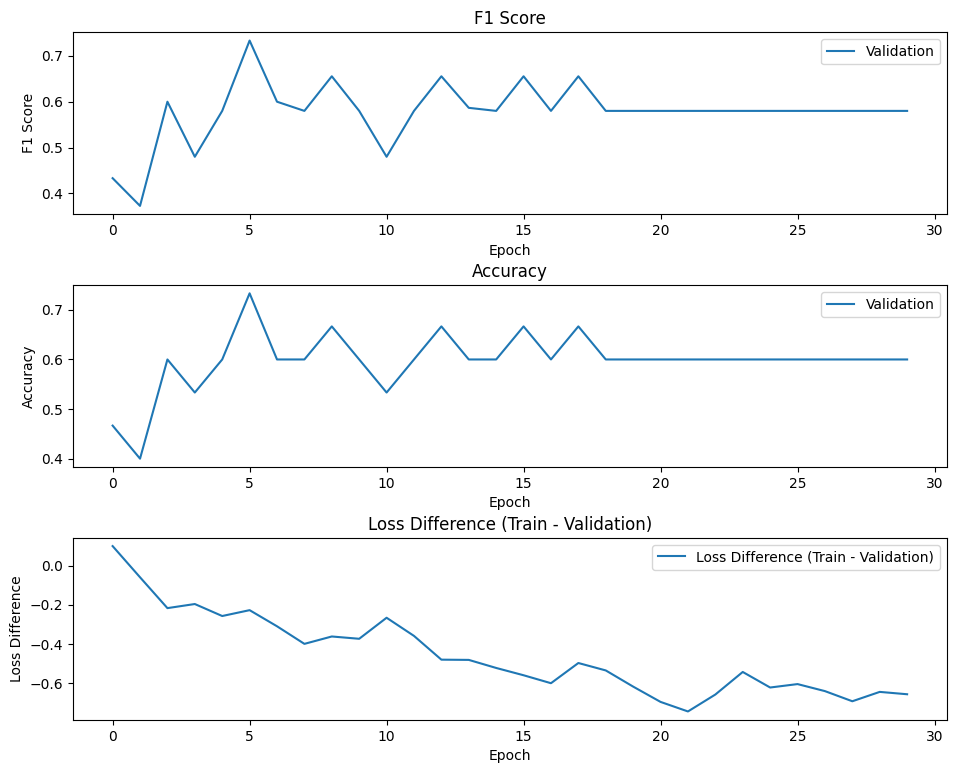

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)


num_epochs = 15
# Set the number of training epochs.
for epoch in range(num_epochs):
    # Training phase for VGG16
    vgg_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
        # Initialize the confusion matrix
        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.
        outputs = vgg_model(images)
        # Perform a forward pass of the images through the VGG16 model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - VGG 16 Training Loss: {epoch_loss:.4f}")

    # Print the training loss for the current epoch.
    # Validation phase
    vgg_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            premodel_outputs = vgg_model(images)
            premodel_loss = parameter_loss(premodel_outputs, labels)

            val_loss += premodel_loss.item()

            _, predictions = torch.max(premodel_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)


            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))
    #print("Confusion Matrix:")
    #print(confusion)

    val_loss /= len(val_dataloader)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies
    val_f1_scores_vgg.append(val_f1_vgg)      # actual validation F1 score
    val_accuracies_vgg.append(val_accuracy_vgg)      # actual validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_vgg:.4f}, Accuracy: {val_accuracy_vgg:.4f}")
loss_difference_vgg = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]


# Plot the loss difference
axs[2].plot(loss_difference_vgg, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_vgg, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_vgg, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

Google Net

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 89.1MB/s]


Epoch 1/15 - GoogLeNet Training Loss: 1.0094
Epoch 1/15 - Validation Loss: 19.0462, F1 Score: 0.1706, Accuracy: 0.2667
Epoch 2/15 - GoogLeNet Training Loss: 0.8795
Epoch 2/15 - Validation Loss: 16.8444, F1 Score: 0.4696, Accuracy: 0.6000
Epoch 3/15 - GoogLeNet Training Loss: 0.9400
Epoch 3/15 - Validation Loss: 1.9413, F1 Score: 0.3333, Accuracy: 0.3333
Epoch 4/15 - GoogLeNet Training Loss: 0.9272
Epoch 4/15 - Validation Loss: 2.6836, F1 Score: 0.7450, Accuracy: 0.7333
Epoch 5/15 - GoogLeNet Training Loss: 0.6414
Epoch 5/15 - Validation Loss: 1.7809, F1 Score: 0.2932, Accuracy: 0.3333
Epoch 6/15 - GoogLeNet Training Loss: 0.6796
Epoch 6/15 - Validation Loss: 1.5653, F1 Score: 0.4789, Accuracy: 0.5333
Epoch 7/15 - GoogLeNet Training Loss: 0.6729
Epoch 7/15 - Validation Loss: 2.0211, F1 Score: 0.4541, Accuracy: 0.4667
Epoch 8/15 - GoogLeNet Training Loss: 0.5611
Epoch 8/15 - Validation Loss: 1.9636, F1 Score: 0.4400, Accuracy: 0.4000
Epoch 9/15 - GoogLeNet Training Loss: 0.7306
Epoch 9/1

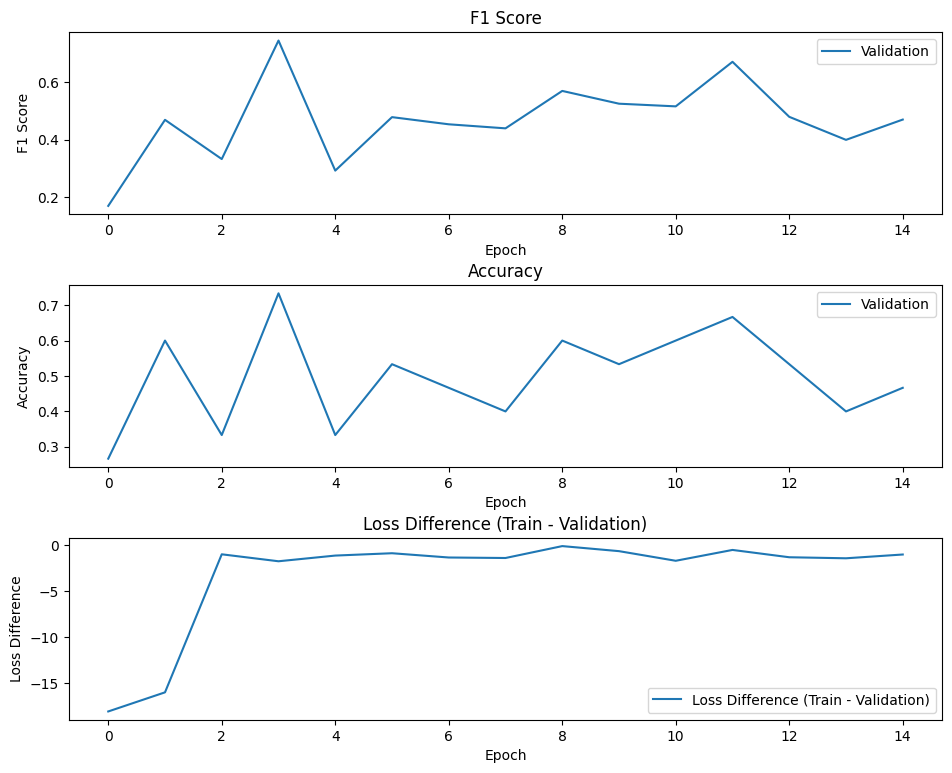

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []

pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

track_time_google = time.time()

num_epochs = 15
for epoch in range(num_epochs):
    # Training phase for GoogLeNet
    googlenet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU when available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = parameter_loss(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
    #print("Confusion Matrix:")
    #print(confusion)
    # Print the validation loss, F1 score, and accuracy for the current epoch.

    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

loss_difference_google = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]



finish_end_time_google = time.time()

# Calculate the total training time
total_time_google = finish_end_time_google - track_time_google
print(total_time_google)

# Plot the loss difference
axs[2].plot(loss_difference_google, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_google, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_score_google, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

NameError: ignored

# Plot and model evaluation

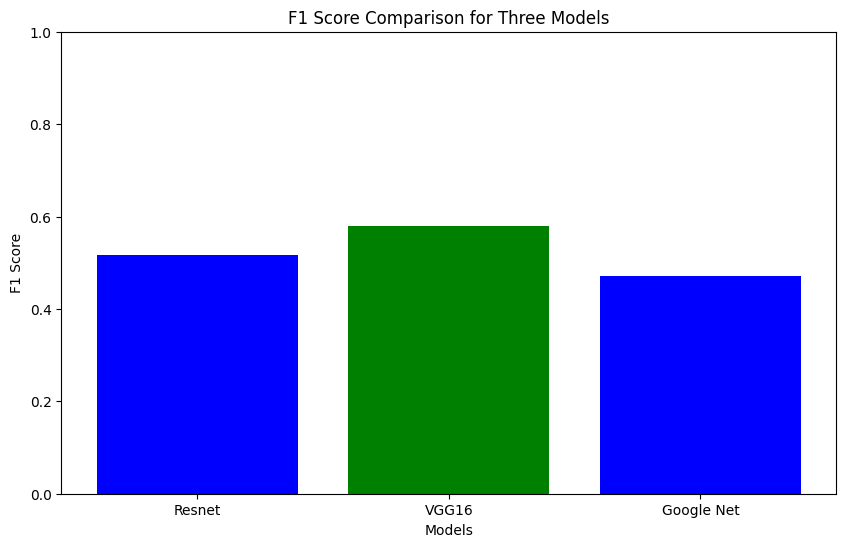

In [ ]:
model_names = ['Resnet', 'VGG16', 'Google Net']
f1_scores = []

f1_scores.append(val_f1_pre)
f1_scores.append(val_f1_vgg)
f1_scores.append(val_f1_google)

best_model_idx = f1_scores.index(max(f1_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Three Models')
plt.ylim(0, 1)
plt.show()

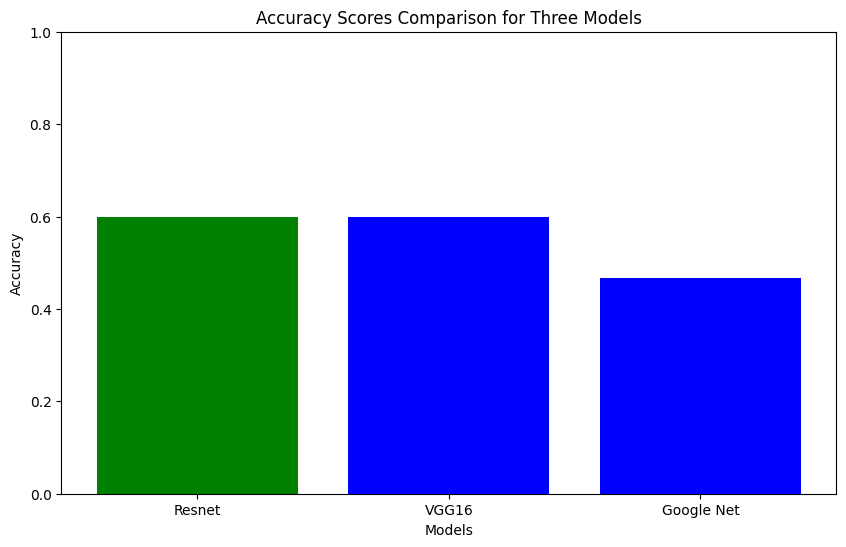

In [ ]:
##################################################
# MODEL ACCURACY COMPARISON
##################################################

model_names = ['Resnet', 'VGG16', 'Google Net']
accuracy_scores = []

accuracy_scores.append(val_accuracy_pre)
accuracy_scores.append(val_accuracy_vgg)
accuracy_scores.append(val_accuracy_google)

best_model_idx = accuracy_scores.index(max(accuracy_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, accuracy_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores Comparison for Three Models')
plt.ylim(0, 1)
plt.show()

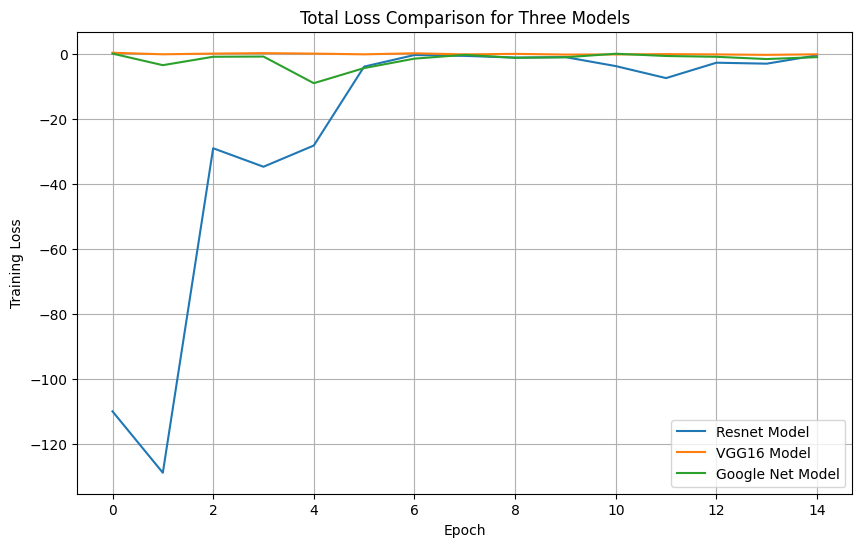

In [ ]:
##################################################
# Plot Learning Curves of Training and Validation
##################################################

# total loss curves for three models stored in variables
model_names = ['Resnet Model', 'VGG16 Model', 'Google Net Model']
loss_curves = []  # Initialize an empty list for loss curves


loss_curves.append(loss_difference_pre)
loss_curves.append(loss_difference_vgg)
loss_curves.append(loss_difference_google)

# Create a line plot for loss curves
plt.figure(figsize=(10, 6))

for i, loss_curve in enumerate(loss_curves):
    plt.plot(loss_curve, label=model_names[i])

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Total Loss Comparison for Three Models')
plt.legend()
plt.grid(True)
plt.show()


Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


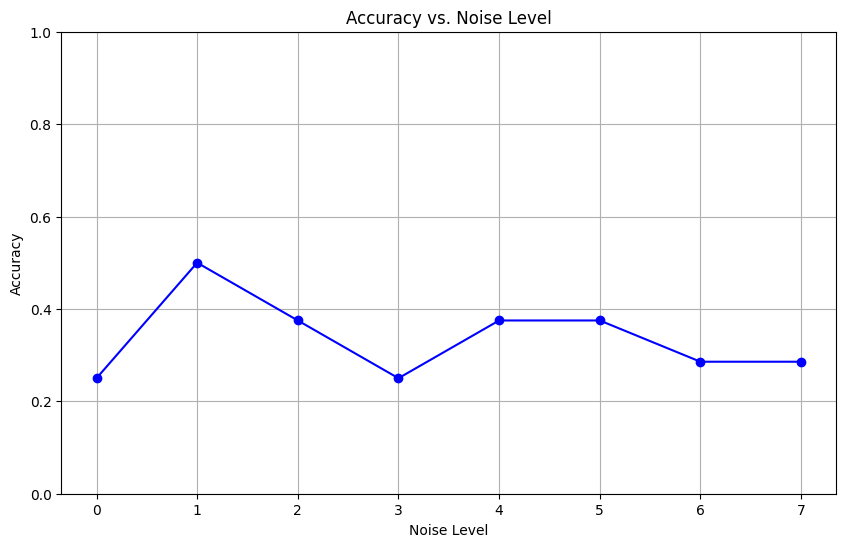

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold

# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create a list to store accuracy scores for each fold
fold_accuracies = []

# Create a list to store the levels of noise
noise_levels = []

# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [stacked_dataset[idx] for idx in train_index]
    val_data = [stacked_dataset[idx] for idx in val_index]

    #Convert labels to numpy array for indexing
    stacked_labels = np.array(stacked_labels)

    # Class weights
    weights_of_classes = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    train_class_weights = weights_of_classes[stacked_labels[train_index]]

    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)

    # Create the data loaders with weighted sampling
    batch_size = 8
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Calculate accuracy for the current fold
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    # Append accuracy and noise level to respective lists
    fold_accuracies.append(accuracy)
    noise_levels.append(fold)

# Create a line plot to show accuracy vs. noise level
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, fold_accuracies, marker='o', linestyle='-', color='blue')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Level')
plt.xticks(noise_levels)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

#Running time section

Resnet Model

In [10]:
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device
resnet_model = resnet_model.to(device)

#Loss function
parameter_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)


# Lists to store training and validation losses, F1 scores and running time
train_losses = []
val_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []
running_times_pre = []

# Percentages of data to consider
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Store running times and data sizes
data_sizes = []

for percentage in percentages:
    # Calculate the number of elements to consider for the given percentage
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

    # Measure the start time
    start_time = time.time()

#############################################
## Training loop (using subset)
#############################################

    resnet_model.train()
    running_loss = 0.0
    for images, labels in subset_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = parameter_loss(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Percentages of dataset of {percentage} - ResNet50 percentages Loss: {epoch_loss:.4f}")

##############################################
#Validation part with a new subset
#############################################
    num_elements_val = len(val_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size, shuffle=True)

    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = parameter_loss(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to lists
    train_losses.append(running_loss)
    val_losses.append(val_loss)

    print(f"Percentages of dataset of {percentage} - ResNet50 percentages validation: {val_loss:.4f}")

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)
 #   val_accuracies_pre.append(val_accuracy_pre)

    # Append the running times for this percentage to the main list
    # Measure the end time
    end_time = time.time()

    # Calculate the running time for this percentage
    percentage_running_time = end_time - start_time
    running_times_pre.append(percentage_running_time)

    # Append the running time and corresponding data size to the lists
    data_sizes.append(num_elements)

    print(f"Percentages of dataset of {percentage} - ResNet50 F1 score: {val_f1_pre:.4f}")

#loss_difference_pre =[val_loss - train_loss for train_loss, val_loss in zip(train_losses, val_losses)]
#average_total_loss = sum(loss_difference_pre) / len(loss_difference_pre)
#print(f"Average Total Loss Difference: {average_total_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


Percentages of dataset of 10 - ResNet50 percentages Loss: 0.0970
Percentages of dataset of 10 - ResNet50 percentages validation: 0.3647
Percentages of dataset of 10 - ResNet50 F1 score: 1.0000
Percentages of dataset of 20 - ResNet50 percentages Loss: 0.2431
Percentages of dataset of 20 - ResNet50 percentages validation: 1.2619
Percentages of dataset of 20 - ResNet50 F1 score: 0.1667
Percentages of dataset of 30 - ResNet50 percentages Loss: 0.3178
Percentages of dataset of 30 - ResNet50 percentages validation: 0.9813
Percentages of dataset of 30 - ResNet50 F1 score: 0.6667
Percentages of dataset of 40 - ResNet50 percentages Loss: 0.4622
Percentages of dataset of 40 - ResNet50 percentages validation: 1.6154
Percentages of dataset of 40 - ResNet50 F1 score: 0.3333
Percentages of dataset of 50 - ResNet50 percentages Loss: 0.5107
Percentages of dataset of 50 - ResNet50 percentages validation: 1.4786
Percentages of dataset of 50 - ResNet50 F1 score: 0.2571
Percentages of dataset of 60 - ResN

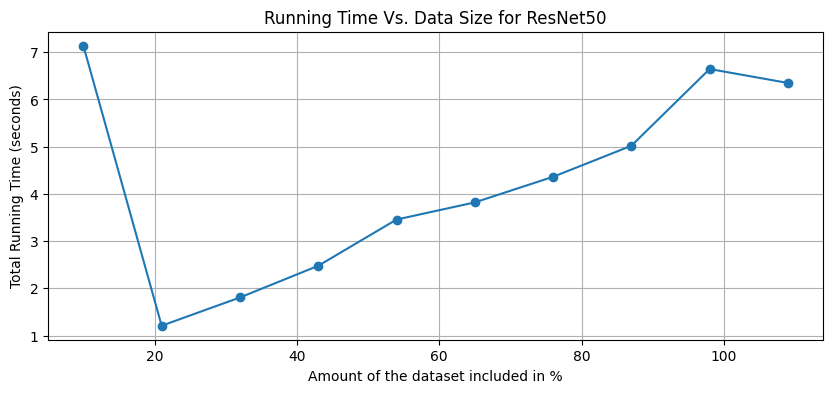

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes, running_times_pre, marker='o', linestyle='-')
plt.title('Running Time Vs. Data Size for ResNet50')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)


plt.show()




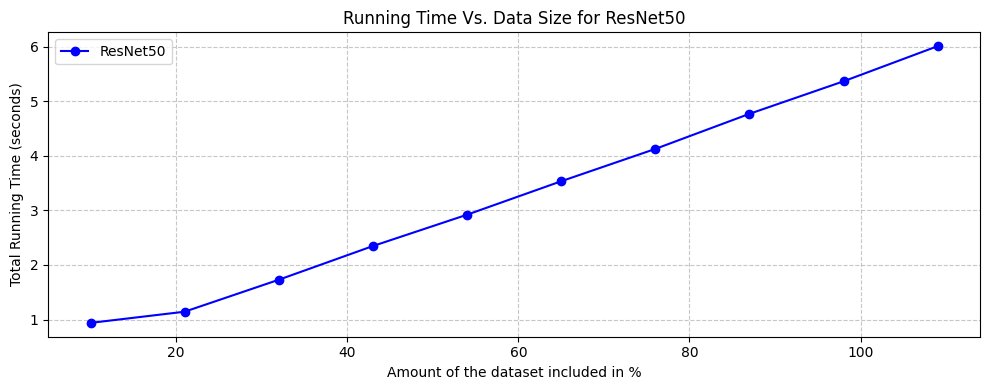

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes, running_times_pre, marker='o', linestyle='-', color='b', label='ResNet50')
plt.title('Running Time Vs. Data Size for ResNet50')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

[]

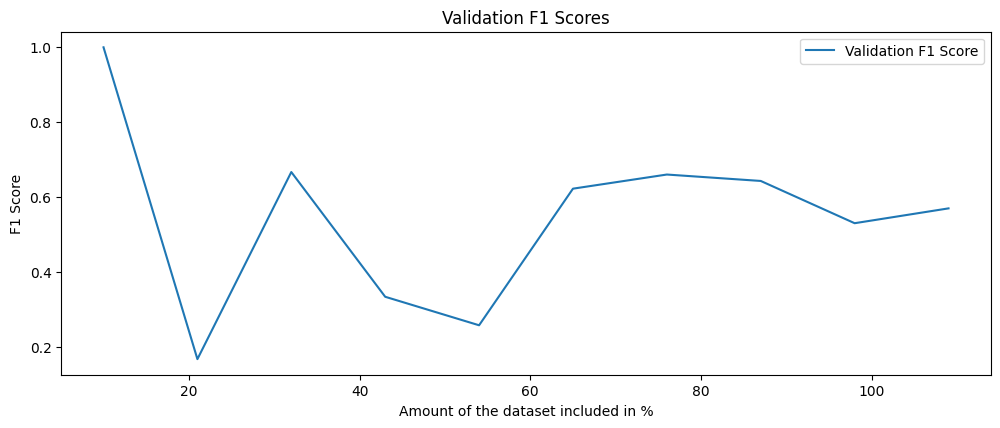

In [11]:
fig, axs = plt.subplots(1,1, figsize=[10, 4])
fig.tight_layout(pad=1.0)

axs.plot(data_sizes, val_f1_scores_pre, label='Validation F1 Score')
axs.set_title('Validation F1 Scores')
axs.set_ylabel('F1 Score')
axs.set_xlabel('Amount of the dataset included in %')
axs.legend()
plt.plot()

In [ ]:
# Plot the loss difference
#fig, axs = plt.subplots(1,1, figsize=[10, 4])
#fig.tight_layout(pad=1.0)

# Plot the loss difference
#axs.plot(data_sizes, loss_difference_pre, label='Loss Difference (Train - Validation)')
#axs.set_title('Loss Difference (Train - Validation)')
#axs.set_ylabel('Loss Difference')
#axs.set_xlabel('Amount of the dataset included in %')
#axs.legend()
#plt.plot()

In [ ]:
# ALL plots together section


fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)

'''
# Plot the loss difference
axs[0].plot(loss_difference_pre, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Amount of the dataset included (*100)')
axs[0].legend()
'''

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores_pre, label='-')
axs[1].set_title('Validation F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Amount of the dataset included (*100)')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies_pre, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Amount of the dataset included (*100)')
axs[2].legend()


# Now, let's create a plot with the running times vs. data sizes
plt.figure(figsize=(12, 5))
plt.plot(data_sizes, running_times_pre, marker='o', linestyle='')
plt.title('Running Time vs. Data Size')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)


plt.show()


VGG 16

In [12]:
weight = models.VGG16_Weights.DEFAULT
vgg_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in vgg_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(vgg_model.classifier) - 1
old_fc = vgg_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
vgg_model.classifier.__setitem__(last_item_index , new_fc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.5MB/s]


In [13]:
vgg_model = vgg_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
'''
Compared to the other one the Learning rate here is 0.01
and NOT 0.001 like in the previous experiment with resnet
'''
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)
#optimizer_vgg = optim.SGD(vgg_model.parameters(), lr=0.024, momentum=0.9)

best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [14]:
# Lists to store training and validation F1 scores and accuracies
set_seeds()
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses_vgg = []
val_losses_vgg = []
running_times_vgg = []
data_sizes_vgg = []

percentages_vgg = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


for percentage in percentages_vgg:
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

    # Measure the start time
    track_time_vgg = time.time()

##############################################
#Training phase for VGG16
#############################################

    vgg_model.train()

    # Set the model to train mode.
    running_loss_vgg = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in subset_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.
        outputs = vgg_model(images)
        # Perform a forward pass of the images through the VGG16 model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss_vgg += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss_vgg = running_loss_vgg / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Percentages of dataset of {percentage} - VGG 16 Training Loss: {epoch_loss_vgg:.4f}")

##############################################
#Validation phase for VGG16
#############################################

    num_elements_val = len(val_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size, shuffle=True)

    vgg_model.eval()
    val_loss_v = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)

            vgg_outputs = vgg_model(images)
            vgg_model_loss = parameter_loss(vgg_outputs, labels)

            val_loss_v += vgg_model_loss.item()

            _, predictions = torch.max(vgg_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    val_loss_v /= len(val_dataloader)
    val_losses_vgg.append(val_loss_v)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies
    val_f1_scores_vgg.append(val_f1_vgg)      # actual validation F1 score
    train_losses_vgg.append(epoch_loss_vgg)

    print(f"Percentages of dataset of  {percentage} - Validation Loss: {val_loss_v:.4f}, F1 Score: {val_f1_vgg:.4f}")

    finish_end_time_vgg = time.time()

    # Calculate the running time for this percentage
    total_time_vgg = finish_end_time_vgg - track_time_vgg
    # Append the running time and corresponding data size to the lists
    running_times_vgg.append(total_time_vgg)
    data_sizes_vgg.append(num_elements)


#loss_difference_vgg = [epoch_loss_vgg - val_loss_v for train_loss, val_loss_v in zip(train_losses_vgg, val_losses_vgg)]

Percentages of dataset of 10 - VGG 16 Training Loss: 0.1364
Percentages of dataset of  10 - Validation Loss: 0.3797, F1 Score: 0.0000
Percentages of dataset of 20 - VGG 16 Training Loss: 0.2436
Percentages of dataset of  20 - Validation Loss: 0.2227, F1 Score: 1.0000
Percentages of dataset of 30 - VGG 16 Training Loss: 0.3395
Percentages of dataset of  30 - Validation Loss: 0.2558, F1 Score: 0.6429
Percentages of dataset of 40 - VGG 16 Training Loss: 0.3773
Percentages of dataset of  40 - Validation Loss: 0.3746, F1 Score: 0.3333
Percentages of dataset of 50 - VGG 16 Training Loss: 0.3957
Percentages of dataset of  50 - Validation Loss: 0.6013, F1 Score: 0.5195
Percentages of dataset of 60 - VGG 16 Training Loss: 0.4495
Percentages of dataset of  60 - Validation Loss: 0.4411, F1 Score: 0.5333
Percentages of dataset of 70 - VGG 16 Training Loss: 0.4973
Percentages of dataset of  70 - Validation Loss: 0.5931, F1 Score: 0.5071
Percentages of dataset of 80 - VGG 16 Training Loss: 0.4651
Pe

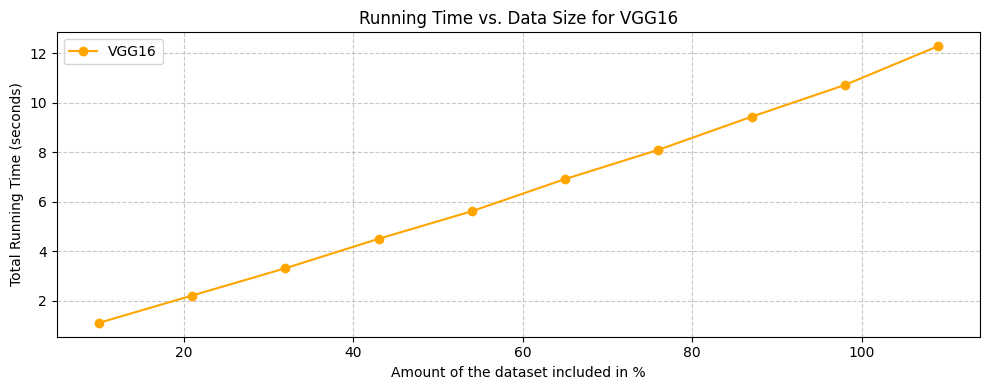

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes_vgg, running_times_vgg, marker='o', linestyle='-', color='orange', label='VGG16')
plt.title('Running Time vs. Data Size for VGG16')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes_vgg, running_times_vgg, marker='o', linestyle='-')
plt.title('Running Time Vs. Data Size for VGG16')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)


plt.show()

Further performances plot

[]

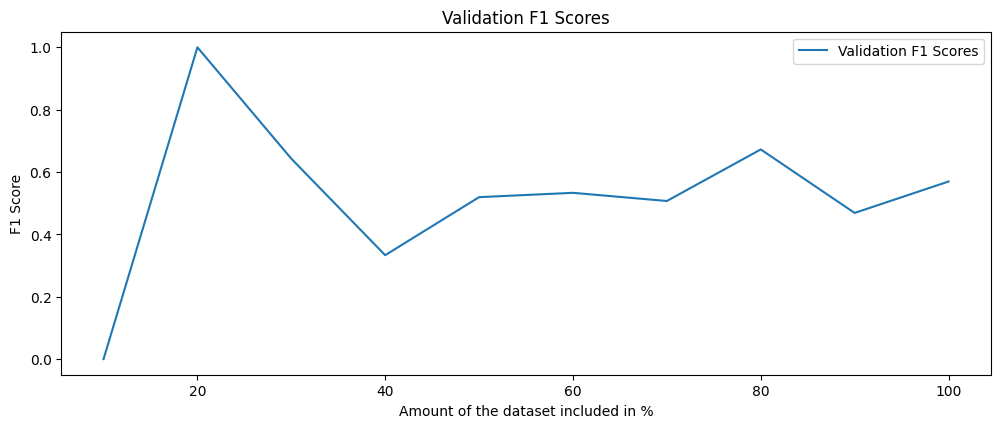

In [15]:
fig, axs = plt.subplots(1,1, figsize=[10, 4])
fig.tight_layout(pad=1.0)

# Plot F1 score
axs.plot(percentages_vgg, val_f1_scores_vgg, label='Validation F1 Scores')
axs.set_title('Validation F1 Scores')
axs.set_ylabel('F1 Score')
axs.set_xlabel('Amount of the dataset included in %')
axs.legend()
plt.plot()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

'''
axs[2].plot(loss_difference_vgg, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Amount of the dataset included (*100)')
axs[2].legend()
'''

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_vgg, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Amount of the dataset included (*100)')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_vgg, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Amount of the dataset included (*100)')
axs[1].legend()

# Now, let's create a plot with the running times vs. data sizes
plt.figure(figsize=(12, 5))
plt.plot(data_sizes_vgg, running_times_vgg, marker='o', linestyle='-')
plt.title('Running Time vs. Data Size')
plt.xlabel('Data Size (Number of Elements)')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)

plt.show()

In [ ]:

'''
plt.figure(figsize=(10, 4))
plt.plot(percentages_vgg,loss_difference_vgg, marker="x", linestyle="--")
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Loss Difference')
plt.title('Loss Difference (Train - Validation)')
plt.grid(True)
plt.show()
'''

Google Net

In [18]:
# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []
data_sizes_google = []
running_times_google = []


pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 131MB/s]


In [19]:
percentages_google = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for percentage in percentages_google:
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)


    track_time_google = time.time()

#############################################
#Training phase for GoogLeNet
#############################################

    googlenet_model.train()
    running_loss = 0.0
    # Initialize the running loss for the current amount of dataset considered.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU when available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Percentages of dataset of  {percentage} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    num_elements_val = len(val_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size, shuffle=True)

#############################################
#Validation phase for GoogLeNet
#############################################

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = parameter_loss(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    print(f"Percentages of dataset of {percentage} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
    #print("Confusion Matrix:")
    #print(confusion)
    # Print the validation loss, F1 score, and accuracy for the current epoch.

    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    finish_end_time_google = time.time()
    total_time_google = finish_end_time_google - track_time_google


    running_times_google.append(total_time_google)
    data_sizes_google.append(num_elements)


#loss_difference_google = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

'''
finish_end_time_google = time.time()

# Calculate the total training time
total_time_google = finish_end_time_google - track_time_google
print(total_time_google)
'''

Percentages of dataset of  10 - GoogLeNet Training Loss: 1.0891
Percentages of dataset of 10 - Validation Loss: 0.3784, F1 Score: 0.0000, Accuracy: 0.0000
Percentages of dataset of  20 - GoogLeNet Training Loss: 0.9404
Percentages of dataset of 20 - Validation Loss: 0.6511, F1 Score: 0.3333, Accuracy: 0.3333
Percentages of dataset of  30 - GoogLeNet Training Loss: 0.9029
Percentages of dataset of 30 - Validation Loss: 1.3068, F1 Score: 0.5000, Accuracy: 0.5000
Percentages of dataset of  40 - GoogLeNet Training Loss: 0.8575
Percentages of dataset of 40 - Validation Loss: 0.4092, F1 Score: 0.5556, Accuracy: 0.5000
Percentages of dataset of  50 - GoogLeNet Training Loss: 0.7482
Percentages of dataset of 50 - Validation Loss: 1.5847, F1 Score: 0.2143, Accuracy: 0.2857
Percentages of dataset of  60 - GoogLeNet Training Loss: 0.7533
Percentages of dataset of 60 - Validation Loss: 2.3357, F1 Score: 0.2963, Accuracy: 0.2222
Percentages of dataset of  70 - GoogLeNet Training Loss: 0.6303
Percen

'\nfinish_end_time_google = time.time()\n\n# Calculate the total training time\ntotal_time_google = finish_end_time_google - track_time_google\nprint(total_time_google)\n'

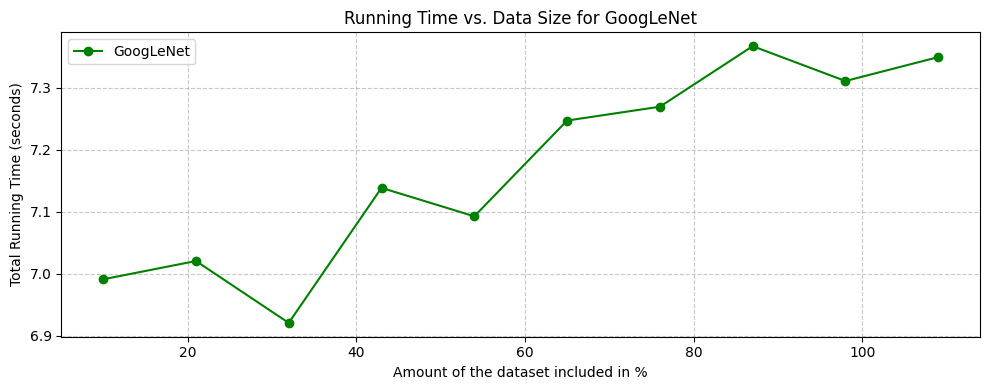

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes_google, running_times_google, marker='o', linestyle='-', color='green', label='GoogLeNet')
plt.title('Running Time vs. Data Size for GoogLeNet')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

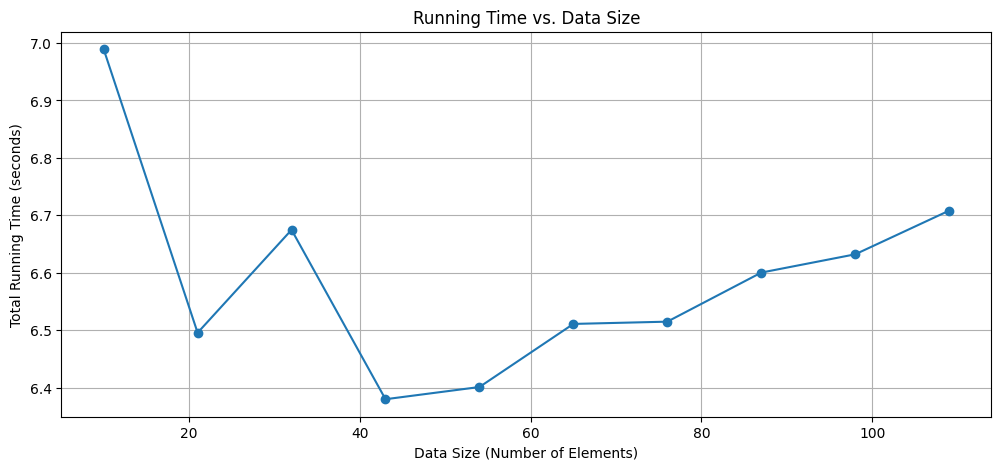

In [21]:
# Now, let's create a plot with the running times vs. data sizes
plt.figure(figsize=(12, 5))
plt.plot(data_sizes_google, running_times_google, marker='o', linestyle='-')
plt.title('Running Time vs. Data Size')
plt.xlabel('Data Size (Number of Elements)')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)

# Show or save the plot as needed
plt.show()

Further performances plot for Google Net

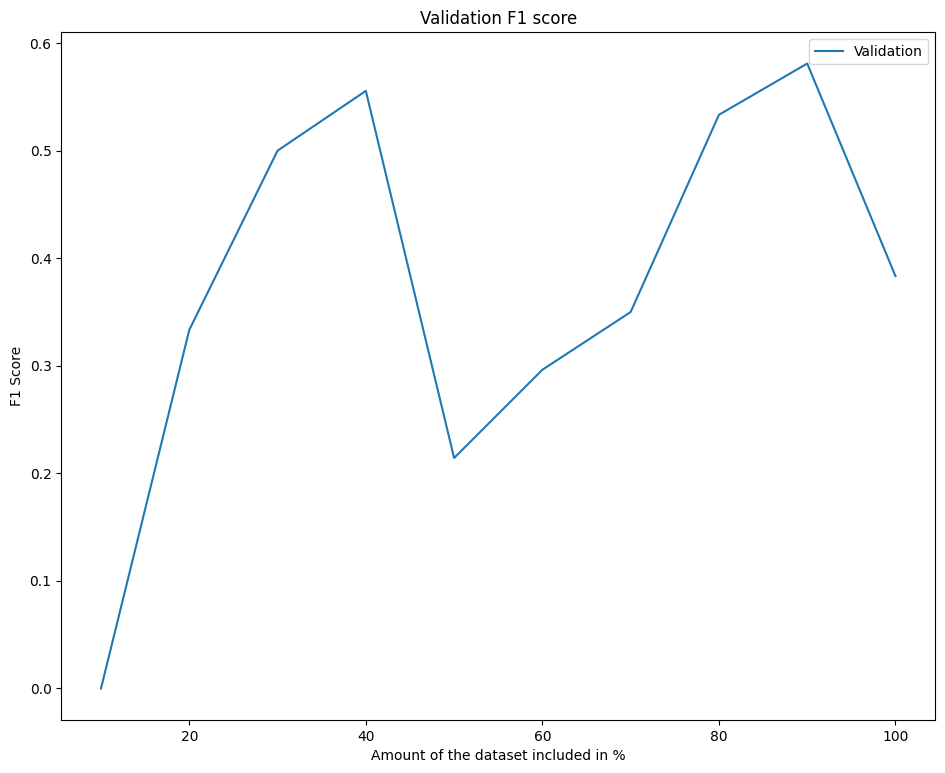

In [20]:
fig, axs = plt.subplots(1, 1, figsize=[10, 8])
fig.tight_layout(pad=3.0)

axs.plot(percentages_google, val_f1_scores_google, label='Validation')
axs.set_title('Validation F1 score')
axs.set_ylabel('F1 Score')
axs.set_xlabel('Amount of the dataset included in %')
axs.legend()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

'''
# Plot the loss difference
axs[2].plot(loss_difference_google, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Amount of the dataset included in %')
axs[2].legend()
'''


# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_google, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Amount of the dataset included in %')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_score_google, label='Validation')
axs[1].set_title('Validation Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Amount of the dataset included in %')
axs[1].legend()

# Now, let's create a plot with the running times vs. data sizes
plt.figure(figsize=(12, 5))
plt.plot(data_sizes_google, running_times_google, marker='o', linestyle='-')
plt.title('Running Time vs. Data Size')
plt.xlabel('Data Size (Number of Elements)')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)

# Show or save the plot as needed
plt.show()

Running times comparison considering T4 GPU

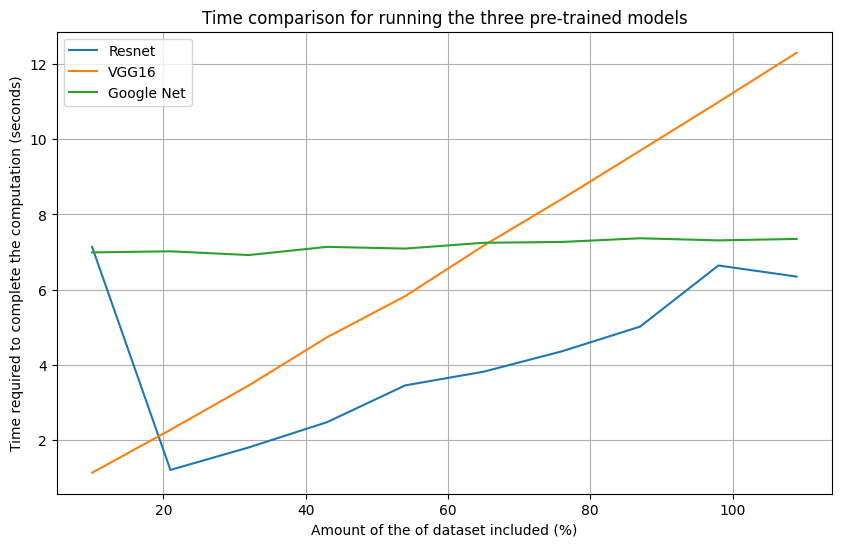

In [24]:
##################################################
# Plot Learning Curves of the performances
##################################################

# total loss curves for three models stored in variables
model_names = ['Resnet', 'VGG16', 'Google Net']
running_times = []

running_times.append(running_times_pre)
running_times.append(running_times_vgg)
running_times.append(running_times_google)

plt.figure(figsize=(10, 6))

for i, running_times in enumerate(running_times):
    plt.plot(data_sizes, running_times, label=model_names[i])

plt.xlabel('Amount of the of dataset included (%)')
plt.ylabel('Time required to complete the computation (seconds)')
plt.title('Time comparison for running the three pre-trained models')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
total_pre = sum(running_times_pre)

In [37]:
list_pre = [running_times_pre[i] + running_times_pre[i+1] for i in range(0, len(running_times_pre), 2)]

# Print for resnet
print("New list:", list_pre)

New list: [8.344077825546265, 4.281909227371216, 7.274566411972046, 9.379051208496094, 12.991569995880127]


In [38]:
total_pre

42.27117466926575

In [17]:
total_vgg = sum(running_times_vgg)

In [39]:
list_vgg = [running_times_vgg[i] + running_times_vgg[i+1] for i in range(0, len(running_times_vgg), 2)]

# Print for vgg16
print("New list:", list_vgg)

New list: [3.4079501628875732, 8.18706202507019, 12.999497413635254, 18.107093572616577, 23.289511680603027]


In [40]:
total_vgg

65.99111485481262

In [18]:
total_googl = sum(running_times_google)

In [ ]:
running_times_google

In [35]:
list_google = [running_times_google[i] + running_times_google[i+1] for i in range(0, len(running_times_google), 2)]

# Print the new list
print("New list:", list_google)

New list: [14.012083530426025, 14.059748888015747, 14.340209007263184, 14.636931657791138, 14.660701036453247]


In [27]:
total_googl

71.81686305999756

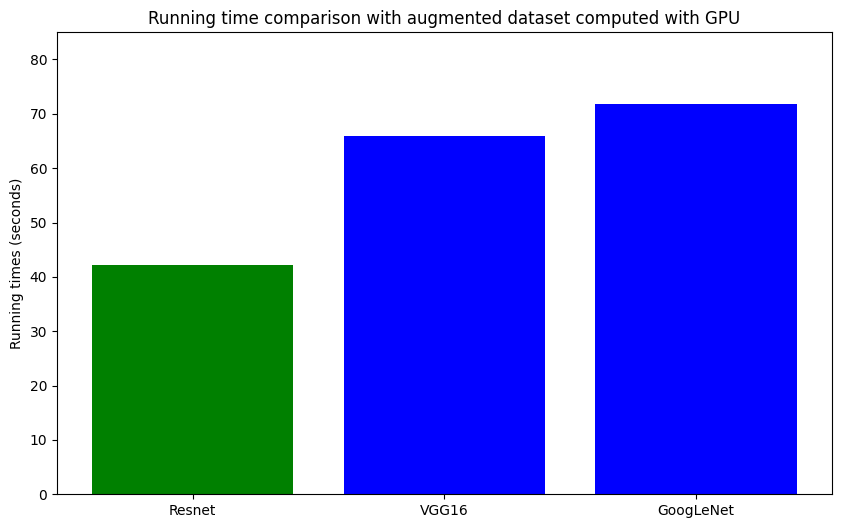

In [25]:
model_names = ['Resnet', 'VGG16', 'GoogLeNet']
running_times = []

running_times.append(total_pre)
running_times.append(total_vgg)
running_times.append(total_googl)

best_model_idx = running_times.index(min(running_times))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, running_times, color=colors)
#plt.xlabel('Models')
plt.ylabel('Running times (seconds)')
plt.title('Running time comparison with augmented dataset computed with GPU')
plt.ylim(0, 85)
plt.show()

In [ ]:

'''
fig, axs = plt.subplots(1, 1, figsize=[10, 8])
fig.tight_layout(pad=3.0)
# Plot the loss difference
axs.plot(percentages_google, loss_difference_google, label='Loss Difference (Train - Validation)')
axs.set_title('Loss Difference (Train - Validation)')
axs.set_ylabel('Loss Difference')
axs.set_xlabel('Amount of the dataset included in %')
axs.legend()
'''